# Formulação do Problema

O problema consiste em **controlar o consumo diário de insumos** (reagentes e descartáveis) em unidades de diagnóstico, garantindo que:

- O estoque esteja disponível para atender à demanda diária;
- Os custos totais sejam minimizados, considerando:
  - Pedido de insumos (custo fixo e custo por unidade);
  - Armazenagem (custo por unidade em estoque);
  - Falta de insumos (custo por unidade não atendida);
  - Desperdício (custo de excesso que ultrapassa a capacidade máxima de estoque).

**Definição em termos de Programação Dinâmica (PD):**

- **Estados (`s`)**: quantidade de insumos em estoque no início do dia.  
- **Decisões (`q`)**: quantidade de insumos a pedir em cada período.  
- **Transição de estados (`s'`)**: estoque após consumo da demanda diária:  
  \[
  s' = \text{max}(0, \text{min}(s + q - d, \text{max\_estoque}))
  \]  
- **Função de custo imediato (`C(s,q,d)`)**: soma ponderada de custo de pedido, custo por unidade, custo de falta e custo de desperdício.  
- **Função objetivo (`V_t(s)`)**: minimizar o custo total esperado no horizonte de planejamento H:  
  \[
  V_t(s) = \min_{q} \mathbb{E}_d \big[ C(s,q,d) + V_{t+1}(s') \big]
  \]  

---

# Estratégia de Implementação

Para resolver o problema, utilizamos três abordagens de Programação Dinâmica:

1. **Recursiva Pura (`V_recursivo`)**  
   - Explora todas as combinações possíveis de estoque, pedidos e demandas.  
   - Serve como referência conceitual, mas cresce exponencialmente e não é viável para horizontes grandes.  

2. **Recursiva com Memorização (`V_memo`)**  
   - Usa `@lru_cache` para armazenar resultados intermediários e evitar recomputações.  
   - Permite resolver problemas maiores rapidamente, mantendo exatidão.  

3. **Iterativa Bottom-Up (`V_iterativo`)**  
   - Preenche uma tabela `V[t][s]` do horizonte final até o início.  
   - Garante desempenho eficiente em tempo e memória, escalável para aplicações práticas.  

**Componentes adicionais:**

- **Função de transição e custo (`proximo_estado_e_custo`)**: calcula o novo estoque e o custo imediato, integrando todos os fatores relevantes do problema.  
- **Função de medição (`medir`)**: compara tempo de execução e pico de memória entre as abordagens.  
- **Controle de reprodutibilidade**: fixação de seeds (`random.seed(42)` e `np.random.seed(42)`) garante resultados consistentes em múltiplas execuções.  

**Resumo da estratégia:**  
- Avaliar todas as decisões possíveis para cada estado e período.  
- Calcular o custo esperado considerando a probabilidade de cada demanda.  
- Escolher a decisão que minimize o custo total esperado.  
- Comparar versões para validar exatidão e medir eficiência.


# Imports e utilitários

In [15]:
import time
import tracemalloc
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache

# Reprodutibilidade
random.seed(42)
np.random.seed(42)

In [16]:
# Função de medição de desempenho


def medir(func, *args):
    tracemalloc.start()
    t0 = time.perf_counter()
    resultado = func(*args)
    t1 = time.perf_counter()
    atual, pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return {
        "resultado": resultado,
        "tempo": t1 - t0,
        "mem_atual": atual,
        "mem_pico": pico
    }

# Parâmetros do problema

In [17]:
H = 6  # horizonte de planejamento (dias)
max_estoque = 10  # capacidade máxima de estoque
demanda_possivel = [0, 1, 2, 3, 4]  # demandas possíveis por dia
prob_demanda = [0.1, 0.2, 0.4, 0.2, 0.1]  # distribuição de probabilidade da demanda

# custos (em unidades monetárias)
c_pedido = 2.0   # custo fixo por pedido
c_estoque = 0.5  # custo por unidade estocada
c_falta = 4.0    # custo por unidade em falta
c_desperd = 1.0  # custo por unidade desperdiçada (vencimento)
c_unit = 1.0     # custo por unidade pedida

# estado inicial
s0 = 5

# Funções

In [18]:
# Função de transição e cálculo de custo

def proximo_estado_e_custo(estoque_atual, pedido, demanda):
    """
    Dado o estoque atual, a quantidade pedida e a demanda,
    retorna o custo e o novo estado.
    """
    # aplica decisão
    estoque_novo = estoque_atual + pedido - demanda

    # custos
    custo_pedido = c_pedido if pedido > 0 else 0
    custo_total = (
        custo_pedido +
        c_unit * pedido +
        c_estoque * max(0, estoque_novo) +
        c_falta * max(0, -estoque_novo) +
        c_desperd * max(0, estoque_novo - max_estoque)
    )

    # limita o estoque ao máximo físico
    estoque_novo = max(0, min(estoque_novo, max_estoque))

    return custo_total, estoque_novo

# Versão Recursiva Pura

def V_recursivo(s, t):
    """Versão puramente recursiva (sem cache)."""
    if t == H:
        return 0.0

    melhor_custo = float('inf')

    for q in range(0, max_estoque - s + 1):
        custo_esperado = 0
        for d, p_d in zip(demanda_possivel, prob_demanda):
            custo, s_prox = proximo_estado_e_custo(s, q, d)
            custo_esperado += p_d * (custo + V_recursivo(s_prox, t + 1))

        melhor_custo = min(melhor_custo, custo_esperado)

    return melhor_custo

# Versão Recursiva com Memorização

@lru_cache(maxsize=None)
def V_memo(s, t):
    """Versão recursiva com memorização."""
    if t == H:
        return 0.0

    melhor_custo = float('inf')
    for q in range(0, max_estoque - s + 1):
        custo_esperado = 0
        for d, p_d in zip(demanda_possivel, prob_demanda):
            custo, s_prox = proximo_estado_e_custo(s, q, d)
            custo_esperado += p_d * (custo + V_memo(s_prox, t + 1))

        melhor_custo = min(melhor_custo, custo_esperado)

    return melhor_custo

    # Versão Iterativa (bottom-up)

def V_iterativo():
    """Versão iterativa (bottom-up)."""
    estados = list(range(max_estoque + 1))
    V = [{s: 0.0 for s in estados} for _ in range(H + 1)]

    for t in reversed(range(H)):
        for s in estados:
            melhor_custo = float('inf')
            for q in range(0, max_estoque - s + 1):
                custo_esperado = 0
                for d, p_d in zip(demanda_possivel, prob_demanda):
                    custo, s_prox = proximo_estado_e_custo(s, q, d)
                    custo_esperado += p_d * (custo + V[t + 1][s_prox])
                melhor_custo = min(melhor_custo, custo_esperado)
            V[t][s] = melhor_custo
    return V

# Execução e comparação

In [23]:
V_memo.cache_clear()

# Recursiva com memorização (top-down)
m_memo = medir(lambda: V_memo(s0, 0))
v_memo = m_memo["resultado"]
print(f"Memo: tempo = {m_memo['tempo']:.4f}s | pico de memória = {m_memo['mem_pico']} bytes")

# Iterativa (bottom-up)
m_iter = medir(V_iterativo)
V_tab = m_iter["resultado"]
v_iter = V_tab[0][s0]
print(f"Iterativa: tempo = {m_iter['tempo']:.4f}s | pico de memória = {m_iter['mem_pico']} bytes")

# Recursiva pura
v_pura = None
if H <= 4 and max_estoque <= 5:  # condição conservadora (Para valores grandes ele não roda, pois demora muito para completar a execução)
    m_pura = medir(lambda: V_recursivo(s0, 0))
    v_pura = m_pura["resultado"]
    print(f"Recursiva pura: tempo = {m_pura['tempo']:.4f}s | pico de memória = {m_pura['mem_pico']} bytes")
else:
    print("Recursiva pura omitida (problema grande, evita travar).")

# Comparação de valores
print("\nComparação de valores:")
print(f"Memo      = {v_memo:.6f}")
print(f"Iterativo = {v_iter:.6f}")
print(f"Pura      = {v_pura:.6f}" if v_pura is not None else "Pura      = None")

# Verificação de consistência
if abs(v_memo - v_iter) < 1e-6:
    print("Memo e Iterativo produzem o mesmo resultado!")
else:
    print("Divergência detectada entre Memo e Iterativo.")

Memo: tempo = 0.0197s | pico de memória = 4863 bytes
Iterativa: tempo = 0.0247s | pico de memória = 6199 bytes
Recursiva pura omitida (problema grande, evita travar).

Comparação de valores:
Memo      = 19.024926
Iterativo = 19.024926
Pura      = None
Memo e Iterativo produzem o mesmo resultado!


# Gráfico de desempenho

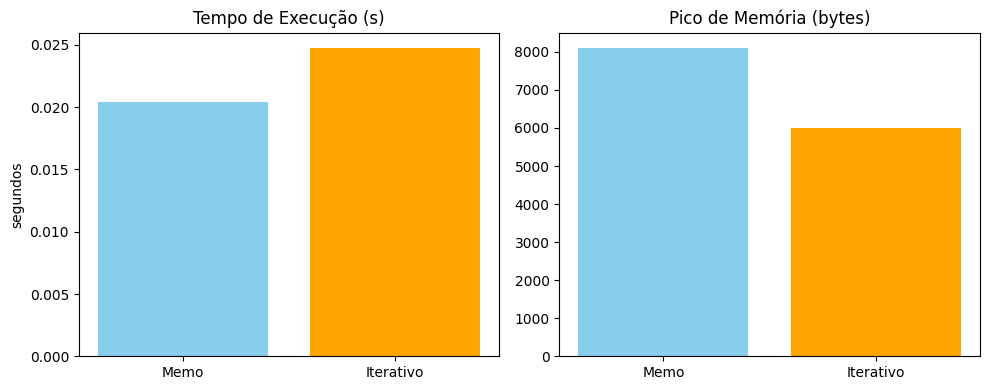

In [22]:
versoes = ["Memo", "Iterativo"]
tempos = [m_memo["tempo"], m_iter["tempo"]]
memorias = [m_memo["mem_pico"], m_iter["mem_pico"]]

plt.figure(figsize=(10, 4))

# tempo
plt.subplot(1, 2, 1)
plt.bar(versoes, tempos, color=['skyblue', 'orange'])
plt.title("Tempo de Execução (s)")
plt.ylabel("segundos")

# memória
plt.subplot(1, 2, 2)
plt.bar(versoes, memorias, color=['skyblue', 'orange'])
plt.title("Pico de Memória (bytes)")

plt.tight_layout()
plt.show()